<a href="https://colab.research.google.com/github/JairAlbertoHuertaDiaz45/Simulaci-n-II/blob/main/M%C3%A9todo_Metropolis_Hastings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align= "center">

**Método de Metropolis-Hastings**

</div>
El **método de Metropolis-Hastings (MH)** es un algoritmo de muestreo basado en **cadenas de Márkov**, empleado para generar muestras de una distribución de probabilidad complicada $f(x)$, especialmente cuando resulta difícil o imposible muestrear directamente de ella.

El propósito fundamental del algoritmo es construir una **cadena de valores** cuya **distribución estacionaria** coincida con $f(x)$. De este modo, tras un número suficiente de iteraciones, las muestras generadas pueden considerarse provenientes de la distribución deseada.

---

<div align= "center">

**Cadenas de Markov**

</div>

Una **cadena de Márkov** es un proceso estocástico en el cual la probabilidad del siguiente estado depende únicamente del estado actual, sin importar los estados previos. Matemáticamente se expresa como:
<div align= "center">
$[
P(X_{t+1} = x' \mid X_t = x, X_{t-1}, \ldots, X_0) = P(X_{t+1} = x' \mid X_t = x)
]$
</div>

Esto significa que el sistema **no tiene memoria**: el futuro depende únicamente del presente.

En el contexto del algoritmo de Metropolis-Hastings, esta propiedad se aprovecha para generar una secuencia:
<div align= "center">
$[
X_0, X_1, X_2, \ldots
]$
</div>

que, tras un número suficiente de iteraciones, **“olvida”** su valor inicial y converge hacia una distribución de probabilidad proporcional a \( f(x) \).

---

En las siguientes secciones se describirá en detalle cómo el método de Metropolis-Hastings permite obtener muestras eficientes mediante la construcción de esta cadena de Márkov.

<div align="center">

Definimos la función:

$f(x_1, x_2) = c \, \exp\left[-\frac{1}{2} \left( x_1^2 x_2^2 + x_1^2 + x_2^2 - 8x_1 - 8x_2 \right) \right]$
</div>
con

$c = \frac{1}{20216.335877}$

<p><i>donde \(c\) es la constante de normalización, aunque no se requiere, ya que el método de Metropolis–Hastings trabaja con proporciones.</i></p>

In [1]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def f(x1, x2):
  return np.exp(-0.5 * (x1**2 * x2**2 + x1**2 + x2**2 - 8*x1 - 8*x2))

In [4]:
x = np.linspace(-2, 6, 100)
y = np.linspace(-2, 6, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

**Graficamos en 2D** para saber como es el comportamiento de la función

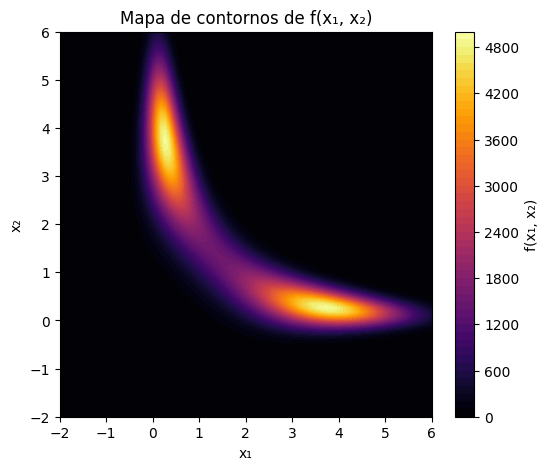

In [10]:
plt.figure(figsize=(6,5))
plt.contourf(X, Y, Z, levels=50, cmap='inferno')
plt.colorbar(label='f(x₁, x₂)')
plt.title("Mapa de contornos de f(x₁, x₂)")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.show()

Una vez graficando en 2D **Graficamos en 3D** para observar el comportamiento de la misma gráfica.

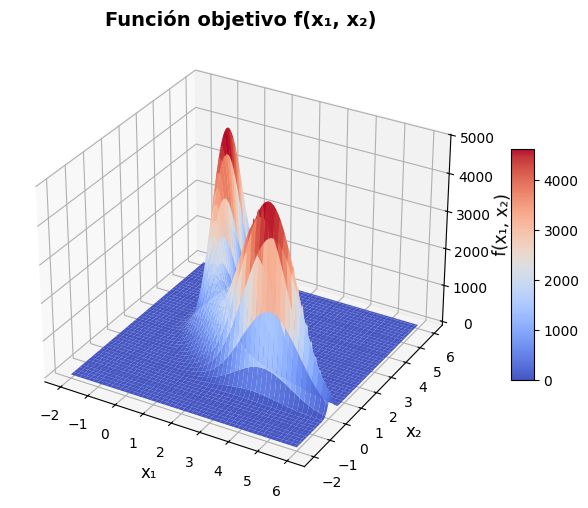

In [11]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

# Superficie con nuevo colormap
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.95, edgecolor='none')

# Etiquetas y título
ax.set_title("Función objetivo f(x₁, x₂)", fontsize=14, fontweight='bold')
ax.set_xlabel("x₁", fontsize=12)
ax.set_ylabel("x₂", fontsize=12)
ax.set_zlabel("f(x₁, x₂)", fontsize=12)

# Barra de color
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()


El **método de Metropolis–Hastings** construye una **cadena de Márkov** $\{ X_t \}$ cuya **distribución estacionaria** corresponde a la función objetivo $f(x_1, x_2)$.

En cada iteración, se genera un **candidato** $Y$ a partir de una **distribución de propuesta** $q(Y \mid X_t)$.  
Comúnmente, \( q \) se elige como una **distribución normal centrada en el valor actual** $X_t$

---

La **probabilidad de aceptación** se calcula mediante:

$$\alpha(X_t, Y) = \min \left( 1, \frac{\pi(Y)}{\pi(X_t)} \right)$$

o, en nuestro caso particular,

$$\alpha = \min \left( 1, \frac{f(Y)}{f(X_t)} \right)$$

Este valor determina si el candidato $Y$ es aceptado o no.  
Cuando $f(Y)$ es mayor que $f(X_t)$, la probabilidad de aceptación tiende a 1,  
lo que hace que la cadena se desplace hacia regiones con **mayor densidad de probabilidad**.

---

## **Algoritmo de Metropolis–Hastings**

**Paso 1:** Inicializar \( X_0 \) y establecer \( t = 0 \).

**Paso 2:** Repetir los siguientes pasos:

1. Generar un candidato $Y \sim q(Y \mid X_t)$
2. Generar un número aleatorio $U \sim U(0,1)$
3. Si $U \leq \alpha(X_t, Y)$, entonces:
   $X_{t+1} = Y$
   De lo contrario:
   $X_{t+1} = X_t$
4. Incrementar $t \rightarrow t + 1$

---

De esta manera, el método garantiza que, con el paso de las iteraciones,  
la cadena $X_t$ converge a una distribución cuya densidad es proporcional a $f(x)$.

In [17]:
def mh(f, N, sigma, x0):

    """
    #Retorna:
    #x1, x2 : arrays con las muestras generadas para cada variable.
    #tasa_aceptacion : float, proporción de propuestas aceptadas.
    """
    x1 = np.zeros(N)  # arreglo para las muestras de la variable x1
    x2 = np.zeros(N)  # arreglo para las muestras de la variable x2

    # Asignar el valor inicial (primer estado de la cadena)
    x1[0] = x0[0]
    x2[0] = x0[1]

    # Contador para registrar cuántas propuestas son aceptadas
    aceptadas = 0

    # --------------------------------------------
    # Bucle principal del algoritmo
    # --------------------------------------------
    for i in range(1, N):

        # Paso 1: generar un candidato Y = (y1, y2)
        # a partir de una distribución normal centrada en el estado actual X_t
        y1 = rd.gauss(x1[i-1], sigma)
        y2 = rd.gauss(x2[i-1], sigma)

        # Paso 2: calcular la probabilidad de aceptación α
        # α = min(1, f(Y)/f(X_t))
        alpha = f(y1, y2) / f(x1[i-1], x2[i-1])
        alpha = min(1, alpha)  # limitar α al máximo de 1

        # Paso 3: generar un número aleatorio uniforme U ~ U(0,1)
        u = rd.random()

        # Paso 4: comparar U con α para decidir si se acepta o no
        if u <= alpha:
            # Aceptar el candidato: la cadena se mueve al nuevo punto Y
            x1[i] = y1
            x2[i] = y2
            aceptadas += 1
        else:
            # Rechazar el candidato: se mantiene el mismo punto anterior
            x1[i] = x1[i-1]
            x2[i] = x2[i-1]

    # --------------------------------------------
    # Al final del bucle: calcular la tasa de aceptación
    # --------------------------------------------
    tasa_aceptacion = aceptadas / N

    # Devolver las muestras y la tasa de aceptación
    return x1, x2, tasa_aceptacion

In [18]:
N = 10000
sigma = 0.7
x0 = (0.0, 0.0)
x1, x2, ac =  mh(f, N, sigma, x0)

In [19]:
ac

0.4081

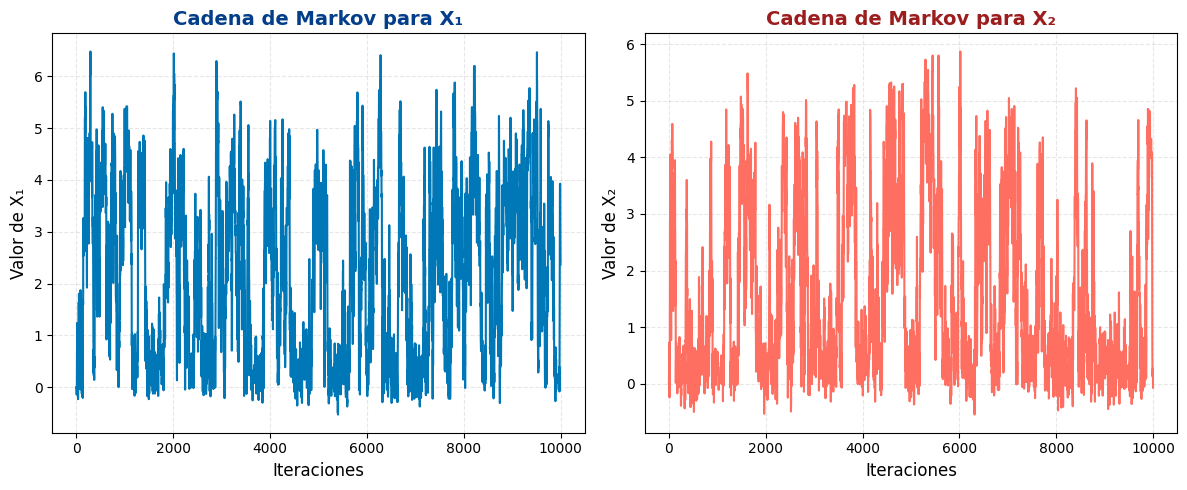

In [20]:
plt.figure(figsize=(12,5))

# --- Cadena de Markov para X₁ ---
plt.subplot(1,2,1)
plt.plot(x1, color='#0077b6', linewidth=1.5)  # azul océano
plt.title("Cadena de Markov para X₁", fontsize=14, fontweight='bold', color='#023e8a')
plt.xlabel("Iteraciones", fontsize=12)
plt.ylabel("Valor de X₁", fontsize=12)
plt.grid(alpha=0.3, linestyle='--')

# --- Cadena de Markov para X₂ ---
plt.subplot(1,2,2)
plt.plot(x2, color='#ff6f61', linewidth=1.5)  # coral cálido
plt.title("Cadena de Markov para X₂", fontsize=14, fontweight='bold', color='#9c1d1d')
plt.xlabel("Iteraciones", fontsize=12)
plt.ylabel("Valor de X₂", fontsize=12)
plt.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


**Histograma**  comparada con la densidad teorica esperada

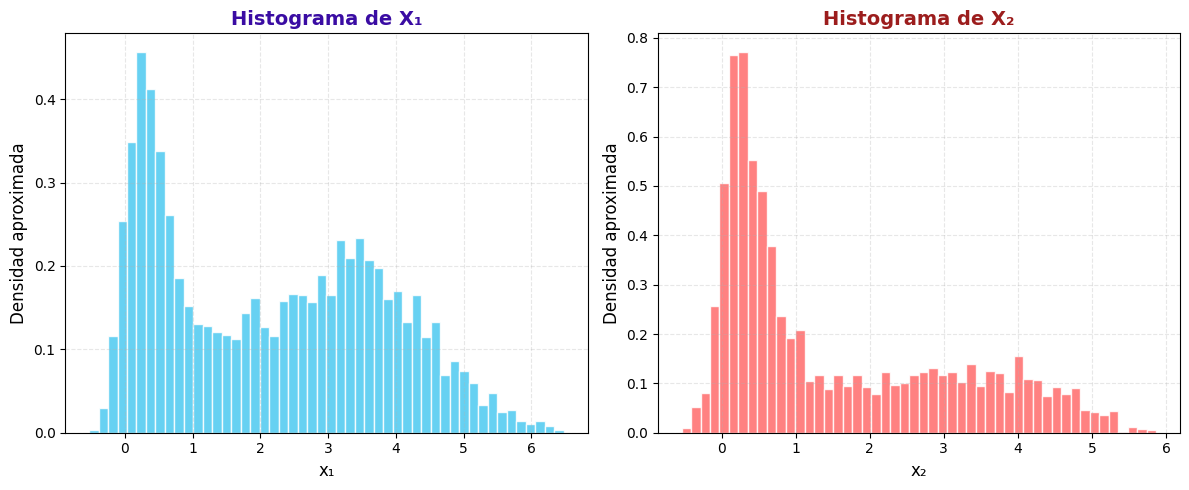

In [21]:
plt.figure(figsize=(12,5))

# --- Histograma de X₁ ---
plt.subplot(1,2,1)
plt.hist(x1, bins=50, density=True, color='#4cc9f0', edgecolor='white', alpha=0.85)
plt.title("Histograma de X₁", fontsize=14, fontweight='bold', color='#3a0ca3')
plt.xlabel("x₁", fontsize=12)
plt.ylabel("Densidad aproximada", fontsize=12)
plt.grid(alpha=0.3, linestyle='--')

# --- Histograma de X₂ ---
plt.subplot(1,2,2)
plt.hist(x2, bins=50, density=True, color='#ff6b6b', edgecolor='white', alpha=0.85)
plt.title("Histograma de X₂", fontsize=14, fontweight='bold', color='#9c1d1d')
plt.xlabel("x₂", fontsize=12)
plt.ylabel("Densidad aproximada", fontsize=12)
plt.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


Finalmente, graficamos los pares de puntos, donde los puntos se agruparan en las zonas de mayor densidad

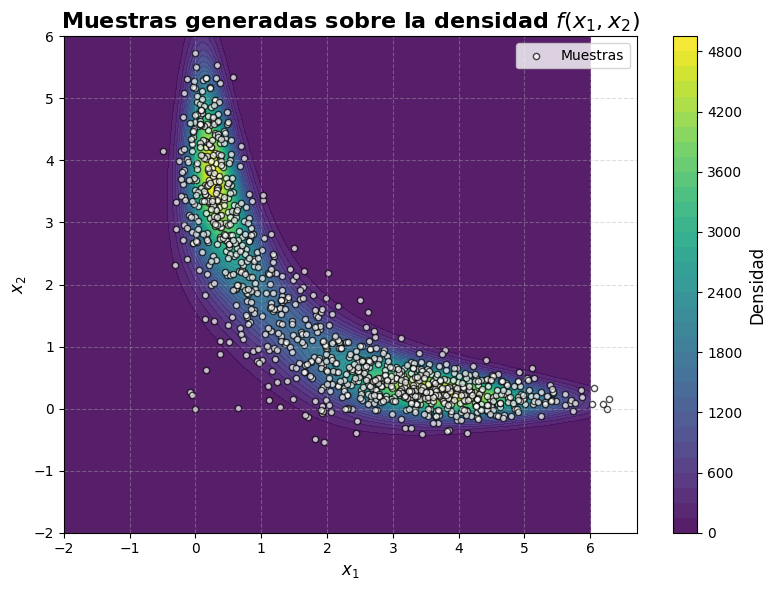

In [23]:
plt.figure(figsize=(8,6))
contour = plt.contourf(X, Y, Z, levels=40, cmap='viridis', alpha=0.9)
plt.scatter(x1[::10], x2[::10], s=20, color='white', edgecolor='black', alpha=0.7, label='Muestras')
plt.title("Muestras generadas sobre la densidad $f(x_1, x_2)$", fontsize=16, weight='bold')
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)
cbar = plt.colorbar(contour)
cbar.set_label("Densidad", fontsize=12)
plt.legend(frameon=True, fancybox=True)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

Usando las muestras generadas vamos a calcular donde $f(x_1,x_2)$ es máxima dadas las muestras generadas

In [25]:
Z_vals = f(x1, x2)
max_idx = np.argmax(Z_vals)
x1_max, x2_max = x1[max_idx], x2[max_idx]

print("Máximo aproximado encontrado en: x1 =", x1_max ,", x2 =" , x2_max)
print(f"Valor de f(x1,x2) ≈ {f(x1_max, x2_max):.5f}")

Máximo aproximado encontrado en: x1 = 0.2617489803215063 , x2 = 3.756402859890785
Valor de f(x1,x2) ≈ 4913.26867
